# Notebook to evaluate Sentinel-1 NRB sample product

In [1]:
#from zipfile import ZipFile

#with ZipFile('Ghana_Accra.zip', 'r') as zipObj:
#   # Extract all the contents of zip file in current directory
#   zipObj.extractall('s1_sample_20200912')

In [2]:
%matplotlib inline

import numpy as np
import xarray as xr
import os, glob
from matplotlib import pyplot as plt

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.colors import LogNorm
import json

## Compare Sentinel-1 NRB sample product over Accra, Ghana to ARDC monthly composite

### Load S1 sample data

In [3]:
def load_s1_sample_combined(s1_sample_path, band):
    fnames = glob.glob(f"{s1_sample_path}/**/*_{band}.tif", recursive=True)
    data = []
    for fname in fnames:
        meta = fname.replace(f"_{band}.tif", "_metadata.json")
        date = np.datetime64(json.load(open(meta))["properties"]["datetime"][:13])
        # print(fname, date)
        data.append(
            xr.open_rasterio(fname, chunks={"x": 1000, "y": 1000})
            .squeeze()
            .to_dataset(name=band)
            .expand_dims({"time": [date]})
        )
    dtype = data[0][band].dtype
    return xr.combine_by_coords(data).astype(dtype).sortby("time")

In [4]:
# sinergise sample

def load_s1_sample(s1_sample_path, band):
    fnames = glob.glob(f"{s1_sample_path}/*/{band}.tiff")
    data = [xr.open_rasterio(fname).squeeze().to_dataset(name=band) for fname in fnames]
    dtype = data[0][band].dtype
    return xr.combine_by_coords(data).astype(dtype)

In [5]:
bands = ["VV", "VH", "MASK", "AREA", "ANGLE"]
s1_sample_path = "s1_sample/N05W001"

data = []
for band in bands:
    data.append(load_s1_sample_combined(s1_sample_path, band))

In [6]:
# bands = ['VV', 'VH', 'MASK', 'AREA', 'ANGLE']
# s1_sample_paths = glob.glob('s1_sample_20200912/*')

# data = []
# for band in bands:
#     for path in s1_sample_paths:
#         date = np.datetime64(path.split('/')[-1].replace('_','-'))
#         data.append(load_s1_sample(path, band).expand_dims({'time':[date]}))


In [7]:
combined = xr.combine_by_coords(data).sortby('time')
combined['ANGLE'] = combined.ANGLE.where(combined.ANGLE!=255).astype('float32')*360./254.255

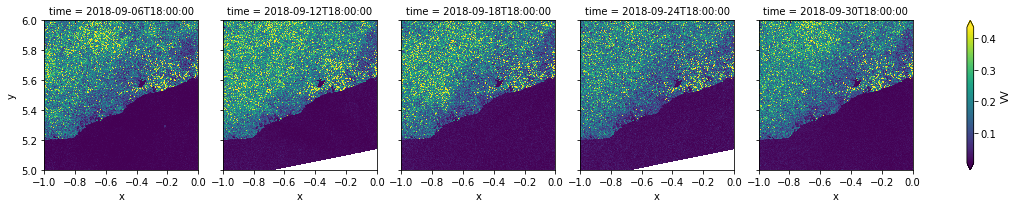

In [8]:
combined.VV.plot.imshow(col='time', robust=True);

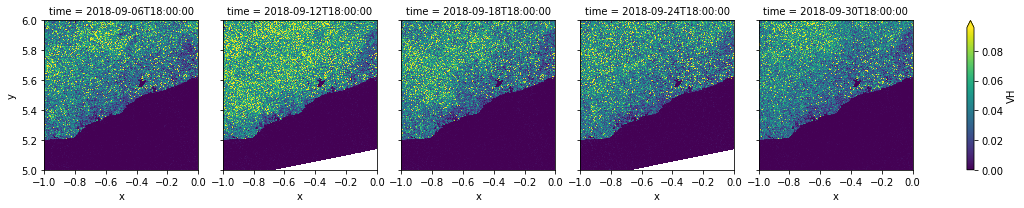

In [9]:
combined.VH.plot.imshow(col='time', robust=True);

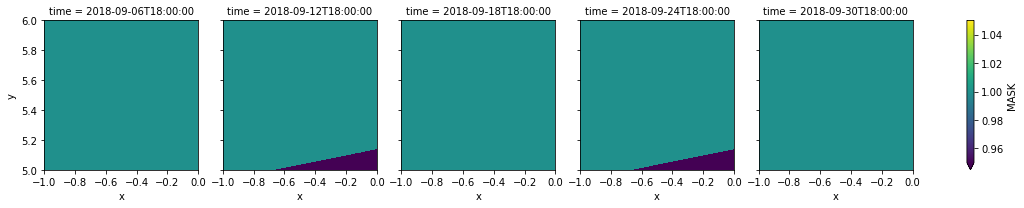

In [10]:
combined.MASK.plot.imshow(col='time', robust=True);

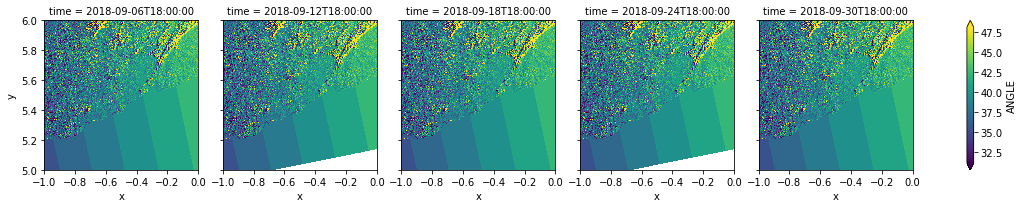

In [11]:
combined.ANGLE.plot.imshow(col='time', robust=True);

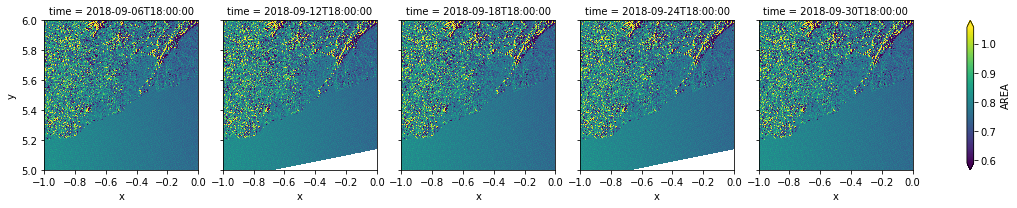

In [12]:
combined.AREA.plot.imshow(col='time', robust=True);

### Caculate mean of VV and VH and convert to dB

In [13]:
mean = 10*np.log10(combined[['VV','VH']].mean(dim='time'))

### Load S1 monthly data

In [14]:
import datacube
dc = datacube.Datacube()

In [15]:
product = 'sentinel1_ghana_monthly'

In [16]:
dc.list_measurements().loc[product] # this data is in dB

,name,dtype,units,nodata,aliases,flags_definition
measurement,,,,,,
vh,vh,float32,1,NaN,[VH],NaN
vv,vv,float32,1,NaN,[VV],NaN


In [17]:
x = combined.x.values[0], combined.x.values[-1]
y = combined.y.values[0], combined.y.values[-1]
monthly = dc.load(product= product, time=str(combined.time.values[0])[:7], x=x, y=y, resolution=(-0.0002, 0.0002)).squeeze()

In [18]:
monthly = monthly.rename({'latitude':'y','longitude':'x'}).rename({'vv':'VV', 'vh':'VH'})

### Visual comparison

Assessment:
1. Overall features look similar, especially over land.
2. Backscatter values over water is lower in Sinergise data, and there are many nan values in VH. Is this because of thermal noise removal?

/env/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 1.0, 'Sinergise')

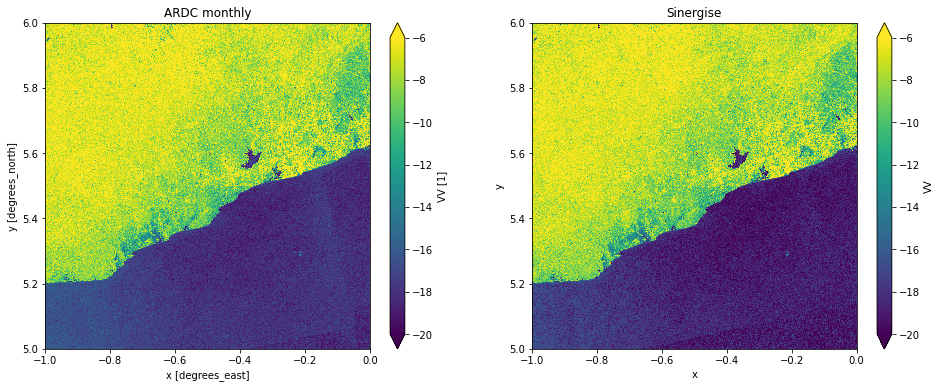

In [19]:
f, ax = plt.subplots(1,2, figsize=(16,6));
monthly.VV.plot.imshow(robust=True, ax=ax[0], vmin=-20, vmax=-6);
ax[0].set_title('ARDC monthly')
mean.VV.plot.imshow(robust=True, ax = ax[1], vmin=-20, vmax=-6);
ax[1].set_title('Sinergise')

/env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 1.0, 'Sinergise')

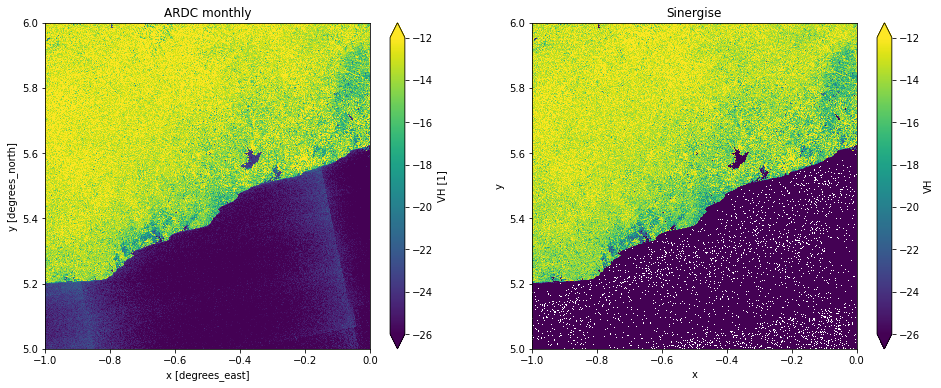

In [20]:
f, ax = plt.subplots(1,2, figsize=(16,6));
monthly.VH.plot.imshow(robust=True, ax=ax[0], vmin = -26, vmax=-12);
ax[0].set_title('ARDC monthly')
mean.VH.plot.imshow(robust=True, ax = ax[1], vmin = -26, vmax=-12);
ax[1].set_title('Sinergise')

## Histograms

Assessment:
1. Sinergise data has a larger dynamic range (presumably due to downsampling/averaging and thermal noise removal) and better seperation of land and water.
2. Difference in VH over land may be explained by thermal noise removal which has a bigger impact for low backscatter.

/env/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


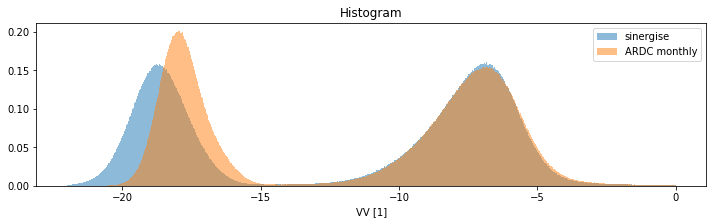

In [21]:
band='VV'
bins = np.arange(-22, 0, 0.01)
mean[band].plot.hist(bins=bins, alpha=0.5, density=True, figsize=(12,3), label='sinergise');
monthly[band].plot.hist(bins=bins, alpha=0.5, density=True, label='ARDC monthly');
plt.legend();

/env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.6/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


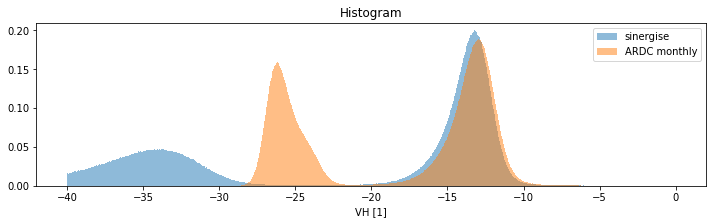

In [22]:
band='VH'
bins = np.arange(-40, 0, 0.01)
mean[band].plot.hist(bins=bins, alpha=0.5, density=True, figsize=(12,3), label='sinergise');
monthly[band].plot.hist(bins=bins, alpha=0.5, density=True, label='ARDC monthly');
plt.legend();

### Effectiveness of RTC 

Assessment:
1. No strong dependence on angle is observed in VV and VH, hence the RTC appears to be effective.
2. Might be useful to check more areas with terrain.

### Load srtm and make sure coordinates match

Only using SRTM to find area with elevation and potential slope, so slight mis-alignment is OK

In [23]:
srtm = dc.load(product= 'srtm', x=x, y=y, resolution=(-0.0002, 0.0002)).squeeze()
srtm = srtm.rename({'latitude':'y','longitude':'x'})
srtm['x'] = combined.x.values
srtm['y'] = combined.y.values

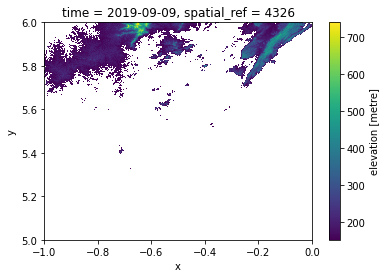

In [24]:
srtm.where(srtm.elevation>150).elevation.plot.imshow();

In [25]:
combined = combined.where(combined.MASK==1)

In [26]:
combined['VV_db'] = 10*np.log10(combined['VV'])
combined['VH_db'] = 10*np.log10(combined['VH'])

In [27]:
# vegetation index
veg = 4*combined.VH/(combined.VH+combined.VV)

In [28]:
# super rough forest area estimate
forest = (veg>0.8) & (combined.VV_db>-15)

/env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))


Band:VV_db, slope=-0.027636712417006493, intercept=-6.6871209144592285, r2=0.014010184369049328


/env/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


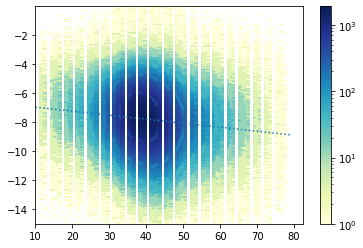

In [29]:
band = 'VV_db'

arr1 = combined['ANGLE'].where(forest).where(srtm.elevation>150).values.flatten()
xedges=list(np.arange(10,80,1))
arr2 = combined[band].where(forest).where(srtm.elevation>150).values.flatten()
yedges = list(np.arange(-15, 0, 0.01))
valid = (~np.isnan(arr1)) & (~np.isnan(arr2))
arr1, arr2 = arr1[valid], arr2[valid]

regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(arr1[:,np.newaxis], arr2[:,np.newaxis])
## The coefficients
print('Band:{0}, slope={1}, intercept={2}, r2={3}'.format(band, regr.coef_[0][0], regr.intercept_[0], 
                                                regr.score(arr1[:,np.newaxis], arr2[:,np.newaxis])))
    
X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
cmname='YlGnBu'
hist, xe, ye= np.histogram2d(arr2, arr1, bins=(yedges, xedges))
plt.pcolor(X, Y, hist, cmap=cmname, norm=LogNorm(1, vmax=hist.max()))
plt.colorbar();
plt.contour(X, Y, np.log10(hist), cmap=cmname, levels=5)
plt.plot(xedges, regr.predict(np.array(xedges)[:,np.newaxis]), ':');

/env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/env/lib/python3.6/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in greater
  return func(*(_execute_task(a, cache) for a in args))


Band:VH_db, slope=-0.021552495658397675, intercept=-11.383759498596191, r2=0.008999270304315687


/env/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


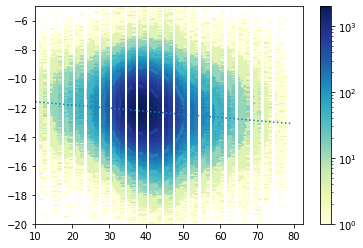

In [30]:
band = 'VH_db'

arr1 = combined['ANGLE'].where(forest).where(srtm.elevation>150).values.flatten()
xedges=list(np.arange(10,80,1))
arr2 = combined[band].where(forest).where(srtm.elevation>150).values.flatten()
yedges = list(np.arange(-20, -5, 0.01))
valid = (~np.isnan(arr1)) & (~np.isnan(arr2))
arr1, arr2 = arr1[valid], arr2[valid]

regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(arr1[:,np.newaxis], arr2[:,np.newaxis])
## The coefficients
print('Band:{0}, slope={1}, intercept={2}, r2={3}'.format(band, regr.coef_[0][0], regr.intercept_[0], 
                                                regr.score(arr1[:,np.newaxis], arr2[:,np.newaxis])))
    
X, Y = np.meshgrid(xedges[:-1], yedges[:-1])
cmname='YlGnBu'
hist, xe, ye= np.histogram2d(arr2, arr1, bins=(yedges, xedges))
plt.pcolor(X, Y, hist, cmap=cmname, norm=LogNorm(1, vmax=hist.max()))
plt.colorbar();
plt.contour(X, Y, np.log10(hist), cmap=cmname, levels=5)
plt.plot(xedges, regr.predict(np.array(xedges)[:,np.newaxis]), ':');